#Download Dataset

In [1]:
!gdown --id 1sQEIPh3bdKQ_1J3g0Z8CRqD6uU7v746l

Downloading...
From: https://drive.google.com/uc?id=1sQEIPh3bdKQ_1J3g0Z8CRqD6uU7v746l
To: /content/dataset.zip
100% 236M/236M [00:01<00:00, 180MB/s]


In [ ]:
!unzip dataset.zip

In [1]:
import pathlib
data_dir = pathlib.Path("../flowers")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4317


#Load dataset

In [2]:
from PIL import Image
import numpy as np
import os

dataset = []
count = 0
for label in os.listdir("../flowers/"):
  for filename in os.listdir(os.path.join("../flowers/",label)):
    count = count + 1
    print("\r" + str(count) + " / " + str(image_count), end="")
    image = Image.open(os.path.join("../flowers/",label,filename))
    image.load()
    image = np.asarray(image, dtype="float32" )
    dataset.append((image, label))

4317 / 4317

In [3]:
import random
print(random.sample(dataset, 10))

[(array([[[246., 242., 243.],
        [250., 246., 247.],
        [253., 251., 252.],
        ...,
        [ 30.,  45.,  14.],
        [ 28.,  43.,  14.],
        [ 30.,  44.,  18.]],

       [[247., 243., 244.],
        [248., 246., 247.],
        [252., 250., 251.],
        ...,
        [ 29.,  42.,  16.],
        [ 26.,  39.,  13.],
        [ 28.,  41.,  15.]],

       [[247., 245., 246.],
        [248., 246., 247.],
        [252., 250., 251.],
        ...,
        [ 26.,  38.,  14.],
        [ 25.,  35.,  11.],
        [ 27.,  37.,  13.]],

       ...,

       [[ 19.,  25.,  11.],
        [ 21.,  24.,  17.],
        [ 24.,  23.,  19.],
        ...,
        [ 52.,  84.,   1.],
        [ 57.,  89.,   4.],
        [ 67.,  97.,  11.]],

       [[ 18.,  24.,  10.],
        [ 19.,  22.,  13.],
        [ 20.,  21.,  16.],
        ...,
        [ 58.,  91.,   2.],
        [ 64.,  97.,   6.],
        [ 73., 104.,  11.]],

       [[ 18.,  25.,   9.],
        [ 18.,  21.,  12.],
        [ 17.,

In [4]:
import random
random.shuffle(dataset)

#Display dataset

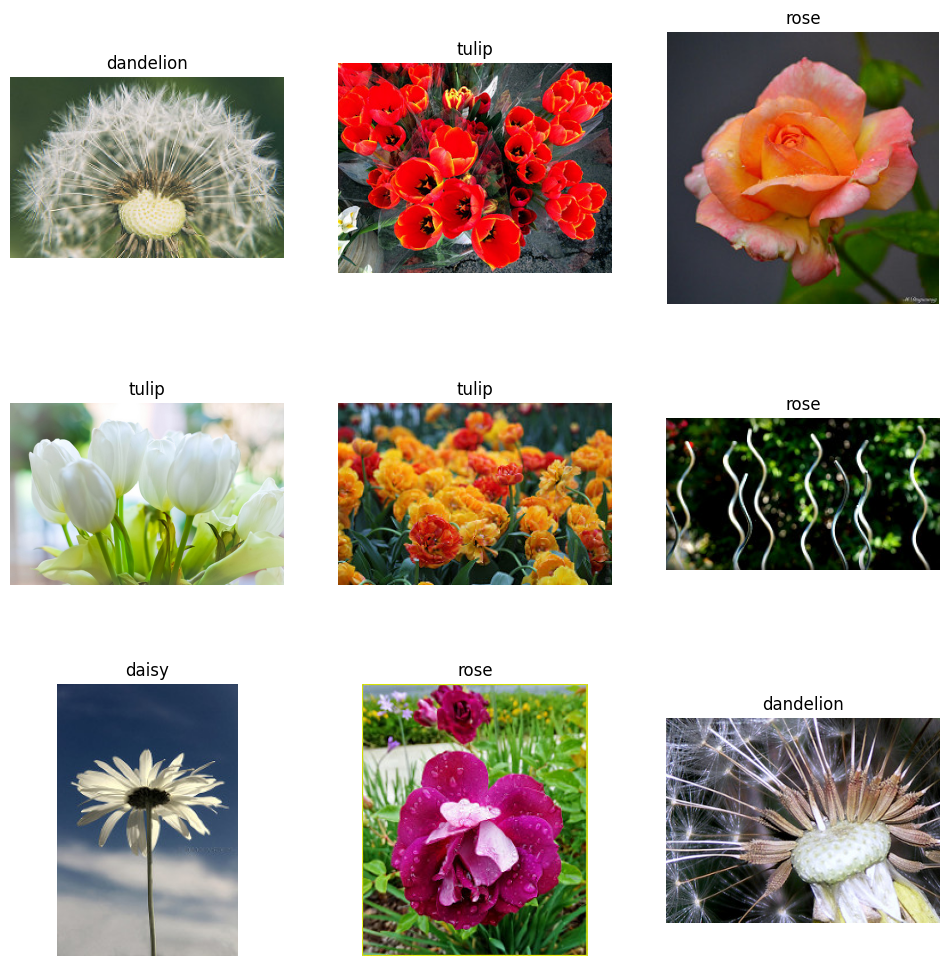

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

for i, ax in enumerate(axs.flat):
  ax.imshow(dataset[i][0].astype("int32"))
  ax.axis('off')
  ax.set_title(dataset[i][1])
plt.show()

#Preprocessing

##Resizing

In [6]:
image_size = (32, 32)

In [7]:
import cv2
resized = []
for d in dataset:
  resized.append((cv2.resize(d[0], image_size), d[1]))

In [8]:
dataset = resized

##Reshape

In [9]:
images = np.asarray([d[0] for d in dataset])
print(images.shape)

(4317, 32, 32, 3)


In [10]:
images = images.reshape(len(images), -1)
print(images.shape)

(4317, 3072)


##Normalization

In [11]:
images = images.astype(np.float32) / 255.

#K-Means Clustering

In [13]:
from sklearn.cluster import MiniBatchKMeans
number_clusters = 5
kmeans = MiniBatchKMeans(n_clusters=number_clusters, n_init=3)
kmeans.fit(images)

MiniBatchKMeans(n_clusters=5, n_init=3)

In [14]:
kmeans.labels_

array([2, 2, 2, ..., 4, 3, 4], dtype=int32)

##Map clusters to classes

In [15]:
def map_clusters_classes(kmeans, classes, clusters):
  
    mapping = {}

    for i in range(kmeans.n_clusters):
        res = []
        row = np.where(i == clusters)[0]

        if 0 == len(row):
            mapping[i] = 0
            continue

        for j in range(len(row)):
            res.append(classes[row[j]])

        mapping[i] = np.bincount(res).argmax()
        
    return mapping

def inference(kmeans, images, classes):
    clusters = kmeans.predict(images)
    mapping = map_clusters_classes(kmeans, classes, clusters)
    predicted_classes = np.zeros(len(clusters)).astype(np.uint8)
    for i in range(len(clusters)):
        predicted_classes[i] = mapping[clusters[i]]
    return predicted_classes

In [16]:
labels_classes_mapping = {"daisy":0,"dandelion":1,"rose":2,"sunflower":3,"tulip":4}
classes = [labels_classes_mapping[d[1]] for d in dataset]
classes = np.asarray(classes)
predicted_classes = inference(kmeans, images, classes)
print(predicted_classes[:20])
print(classes[:20])

[1 1 1 0 1 1 1 1 1 4 1 1 1 1 1 1 4 3 4 1]
[1 4 2 4 4 2 0 2 1 1 2 1 4 0 3 2 2 4 4 0]


#Evaluation

In [17]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(classes, predicted_classes)
print('Accuracy: {}\n'.format(acc))

Accuracy: 0.28538336807968495



In [ ]:
number_clusters = [5, 10, 16, 36, 64, 144, 256, 1024, 2048, 4098]
acc_list = []

for n_clusters in number_clusters:
    model = MiniBatchKMeans(n_clusters=n_clusters, n_init=3)
    model.fit(images)
    predicted_classes = inference(model, images, classes)
    acc = accuracy_score(classes, predicted_classes)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))


Accuracy: 0.28422515635858236

Accuracy: 0.3152652304841325

Accuracy: 0.3166550845494556

Accuracy: 0.3655316191799861

Accuracy: 0.3873059995367153

Accuracy: 0.4118600880240908

Accuracy: 0.43502432244614314

Accuracy: 0.5471392170488766



In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(number_clusters, acc_list, label='accuracy', marker='^')
ax.legend(loc='best')
ax.grid('on')
ax.set_title('Accuracy per each cluster number')
plt.show()

In [ ]:
Plus le nombre de cluster augmente, plus la précision semble s'améliorer.